# DenStream

官方文档：[DenStream](https://riverml.xyz/latest/api/cluster/DenStream/)

## 1. DenStream 算法介绍

**DenStream** 是一种用于流数据聚类的算法，属于基于密度的聚类方法（类似于 DBSCAN），但是它特别设计用于处理动态变化的流数据。流数据指的是不断到来的数据，通常是高维、具有噪声和不规则分布的。DenStream 是一种增量式的聚类方法，能够在数据到达时实时更新聚类结果，而不需要重新处理整个数据集。

DenStream 的核心思想是使用“核心对象”和“边界对象”来定义聚类。具体来说，算法将数据点分为三类：
1. **核心对象**（Core Objects）：这些点是某个簇的密度核心，周围有足够多的邻居点。
2. **边界对象**（Border Objects）：这些点距离核心对象较远，但在核心对象的邻域内。
3. **噪声对象**（Noise Objects）：这些点既不属于任何核心对象，也不接近任何边界对象。

### DenStream 的关键技术
1. **Micro-clusters（微簇）**：DenStream 维护一组微簇，这些微簇是对数据流的压缩表示。每个微簇都存储了一些关键的统计信息（如均值和密度等），以便在新数据到来时能够快速更新。
2. **动态更新**：随着新数据的到来，算法会实时更新微簇的状态，判断是否有新的簇形成或旧的簇解散。
3. **时间窗机制**：为了处理流数据的动态特性，DenStream 会使用一个滑动时间窗，来确保过时的数据不会对聚类结果产生影响。

### 优点
- **处理动态数据**：能够适应数据流的变化，不断调整聚类结果。
- **在线聚类**：无需存储所有历史数据，适用于大规模数据流。
- **噪声鲁棒性**：通过密度的定义，能够有效识别噪声数据。

### 应用场景
- **实时数据流分析**：如社交媒体数据、传感器数据、金融交易数据等。
- **物联网（IoT）数据聚类**：处理从不同设备实时生成的传感器数据。
- **动态市场分析**：实时聚类和分类商品或消费者行为数据。

总之，DenStream 是一个强大的流数据聚类工具，适用于各种需要实时分析和动态调整聚类结果的场景。

（以上内容来自 ChatGPT 4o，略有修改）

In [1]:
# !pip install river

import numpy as np
import utils

from river import cluster, stream

## 2. DenStream 的简单示例

In [2]:
np.random.seed(67)
X = np.concatenate([
    np.random.randn(100, 2) + np.array([5, 5]),
    np.random.randn(100, 2) + np.array([-1, -5]),
    np.random.randn(100, 2) + np.array([5, -3]),
    np.random.randn(100, 2) + np.array([-2.5, 5]),
    np.random.randn(100, 2) + np.array([0, 0]),
])

# 打乱数据
np.random.shuffle(X)

X.shape

(500, 2)

In [3]:
# 初始化 DenStream 聚类器
denstream = cluster.DenStream(decaying_factor=0.01,
                              beta=0.5,
                              mu=2.5,
                              epsilon=0.5,
                              n_samples_init=10)

# 对数据流进行增量学习
for x, _ in stream.iter_array(X):
    denstream.learn_one(x)
    # print(f"Data point: {x} -> Cluster: {denstream.predict_one(x)}")

In [4]:
# 预测新的数据点
prediction = denstream.predict_one({0: -1, 1: -2})

# 输出预测结果
print(f"Predicted cluster for point (-1, -2): {prediction}")

Predicted cluster for point (-1, -2): 8


In [5]:
# 打印聚类中心点
denstream.centers

{0: {0: 11.467433622623323, 1: 4.6488637481733806},
 1: {0: -2.6739570604504617, 1: 4.982593967533832},
 2: {0: -1.3355245562781521, 1: -5.6764173637736075},
 3: {0: 4.750693741342936, 1: -2.8052587534996216},
 4: {0: 4.913129746477875, 1: 4.961082181189485},
 5: {0: -0.6001094188272731, 1: -4.303819234196754},
 6: {0: -1.9314549916959123, 1: 3.2401220420997814},
 7: {0: 1.4894187207054983, 1: 0.08162859566406364},
 8: {0: -0.5445010185541337, 1: -0.7326631229403422},
 9: {0: -0.9617175505695593, 1: 0.48571087877260166},
 10: {0: -0.1805423115634554, 1: 1.5633059760047083},
 11: {0: 0.5262700481672132, 1: 0.886449533390405}}

## 3. DenStream 的可选参数

参数说明：

| 参数                  | 默认值  | 说明                                               |
|----------------------|---------|---------------------------------------------------|
| `decaying_factor`    | `0.25`  | 决定流数据中历史信息的衰减速度，影响历史数据点的权重。     |
| `beta`               | `0.75`  | 决定相对于核心微簇异常点的阈值，值域为 `(0,1]`。         |
| `mu`                 | `2`     | 决定相对于核心微簇异常点的阈值，值域为 `(1/beta, inf)`。 |
| `epsilon`            | `0.02`  | 控制邻域的范围，影响数据点的相似性判定。                 |
| `n_samples_init`     | `1000`  | 初始样本数，用于初始化聚类器的微簇状态。                 |
| `stream_speed`       | `100`   | 单位时间内到达的点数。                                |


In [6]:
# dir(denstream)
# help(denstream)
# denstream??

## 4. 验证：推理结果是否随时间变化

在学习过程中，把预测产生的簇号保存下来。当学习和预测完成以后，再将之前用于学习和预测的数据点预测一遍，对比前后簇号是否发生变化。

In [7]:
# 划分训练数据和测试数据
test_rate = 0.2
train_num = int(len(X) * (1 - test_rate))
x_train, x_test = X[:train_num], X[train_num:]

# 初始化 DenStream 聚类器
denstream = cluster.DenStream(decaying_factor=0.01,
                              beta=0.5,
                              mu=2.5,
                              epsilon=0.5,
                              n_samples_init=10)

# 用于存储数据点和学习过程中的簇号
save_train = dict()

# 对数据流进行增量学习
for i, (x, _) in enumerate(stream.iter_array(x_train)):
    denstream.learn_one(x)
    prediction = denstream.predict_one(x)
    save_train[i] = {'data': x,
                     'cluster': prediction}
    # print(f'Train {i}: {x} -> {prediction}')

# 预测新的数据点
save_test = dict()
for i, (x, _) in enumerate(stream.iter_array(x_test)):
    prediction = denstream.predict_one(x)
    save_test[i] = {'data': x,
                    'cluster': prediction}
    # print(f'Test {i}: {x} -> {prediction}')

In [8]:
# 再将所有的训练和预测数据预测一遍，看是否发生变化

# 再次预测 训练数据
new_save_train = dict()
for i, (x, _) in enumerate(stream.iter_array(x_train)):
    prediction = denstream.predict_one(x)
    new_save_train[i] = {'data': x,
                         'cluster': prediction}
    # print(f'Train {i}: {x} -> {prediction}')

# 再次预测 测试数据
new_save_test = dict()
for i, (x, _) in enumerate(stream.iter_array(x_test)):
    prediction = denstream.predict_one(x)
    new_save_test[i] = {'data': x,
                    'cluster': prediction}
    # print(f'Test {i}: {x} -> {prediction}')

In [9]:
# 训练数据：初次预测与再次预测对比
assert len(save_train) == len(new_save_train)
cnt = 0
for i in save_train.keys():
    is_data_equal = bool(save_train[0]['data'] == new_save_train[0]['data'])
    is_cluster_equal = bool(save_train[0]['cluster'] == new_save_train[0]['cluster'])
    if not (is_data_equal and is_cluster_equal):
        print(f'Train {i}: data_equal={is_data_equal}, cluster_equal={is_cluster_equal}')
        cnt += 1
    if cnt > 5: break

Train 0: data_equal=True, cluster_equal=False
Train 1: data_equal=True, cluster_equal=False
Train 2: data_equal=True, cluster_equal=False
Train 3: data_equal=True, cluster_equal=False
Train 4: data_equal=True, cluster_equal=False
Train 5: data_equal=True, cluster_equal=False


In [10]:
# 测试数据：初次预测与再次预测对比
assert len(save_test) == len(new_save_test)
for i in save_test.keys():
    is_data_equal = bool(save_test[0]['data'] == new_save_test[0]['data'])
    is_cluster_equal = bool(save_test[0]['cluster'] == new_save_test[0]['cluster'])
    if not (is_data_equal and is_cluster_equal):
        print(f'Train {i}: data_equal={is_data_equal}, cluster_equal={is_cluster_equal}')

结论：只有训练阶段的簇号会变，预测阶段簇号就不变了。

## 5. DBSCAN 与 DenStream 效果对比

对比使用 DBSCAN 做全量聚类与使用 DenStream 做流式聚类的效果。

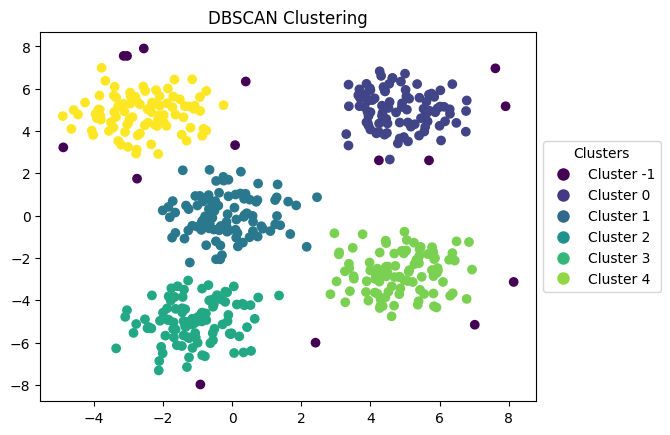

best_params: {'eps': 0.9, 'min_samples': 6}


In [11]:
dbscan_best_params, dbscan_labels = utils.auto_dbscan(data=X)
print(f'best_params: {dbscan_best_params}')

In [12]:
dbscan_labels.shape

(500,)

In [13]:
# 使用 DenStream 流式聚类
def denstream_init(data,
                    decaying_factor=0.01,
                    beta=0.5,
                    mu=2.5,
                    epsilon=0.5,
                    n_samples_init=10):

    # 初始化 DenStream 聚类器
    denstream = cluster.DenStream(decaying_factor=decaying_factor,
                                  beta=beta,
                                  mu=mu,
                                  epsilon=epsilon,
                                  n_samples_init=n_samples_init)

    # 对数据流进行增量学习
    for x, _ in stream.iter_array(data):
        denstream.learn_one(x)

    return denstream

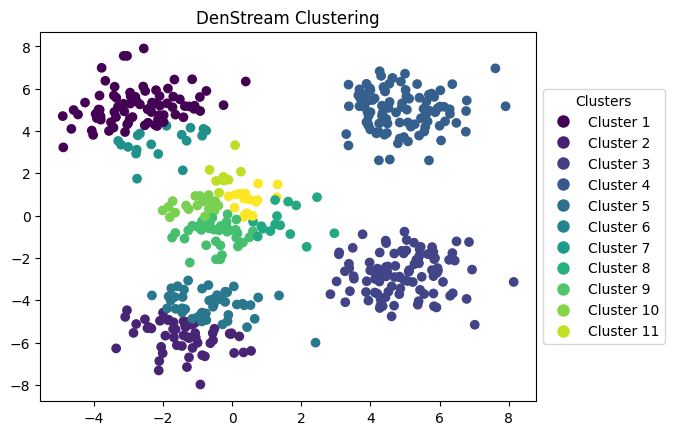

In [14]:
# 对全量数据做流式聚类
denstream = denstream_init(X)

# 对全量数据做预测
denstream_labels = list()
for x, _ in stream.iter_array(X):
    prediction = denstream.predict_one(x)
    denstream_labels.append(prediction)

# 绘图
utils.simple_scatter(data=X,
                     labels=denstream_labels,
                     title='DenStream Clustering')

结论：DenStream 的聚类效果不如 DBSCAN，主要差在全局信号，从局部来看 DenStream 聚得没什么问题。

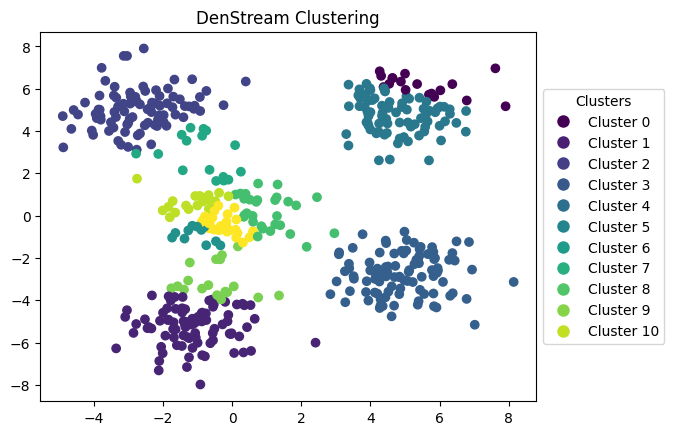

In [15]:
# 流式聚类：使用与 DBSCAN 相同的 epsilon 参数
denstream_epsilon = dbscan_best_params['eps']

# 对全量数据做流式聚类
denstream = denstream_init(X,
                            decaying_factor=0.01,
                            beta=0.75,
                            mu=2,
                            epsilon=denstream_epsilon,
                            n_samples_init=10)

# 对全量数据做预测
denstream_labels = list()
for x, _ in stream.iter_array(X):
    prediction = denstream.predict_one(x)
    denstream_labels.append(prediction)

# 绘图
utils.simple_scatter(data=X,
                     labels=denstream_labels,
                     title='DenStream Clustering')

结论：借用 DBSCAN 的最优参数对 DenStream 帮助不大。